# Preprocessing file
By running all cells in this file the data will be preprocessed for training.
The data will be saved into a .npy file.

In [2]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [ ]:
dataset_dir = os.path.abspath('./sequences/') #Directory of dataset
files = os.listdir(dataset_dir)
input_files = []

# Find files containing the input data

In [4]:
longest_sequence = 0
n_trainimgs = 0
n_testimgs = 0
for file in files:
    if(file.endswith('-inputdata.txt')):
        input_files.append(file)
        if re.match("train", file):
            n_trainimgs += 1
        if re.match("test", file):
            n_testimgs += 1
        with open(os.path.join(dataset_dir, file)) as f:
            sequence_length = len(f.readlines())
            
            if(sequence_length > longest_sequence):
                longest_sequence = sequence_length
                
                
n_inputs = len(input_files)

print('Found ', n_inputs, 'files, and the longest sequance was ', longest_sequence, 'points')
print('Found', n_trainimgs, 'training images and', n_testimgs, 'test images')

Found  70000 files, and the longest sequance was  117 points
Found 60000 training images and 10000 test images


# Load file data into numpy array

In [5]:
data = np.zeros((n_inputs, longest_sequence , 4))

for i, file in enumerate(input_files):
    with open(os.path.join(dataset_dir, file)) as f:
        t = 0
        di = re.findall(r"\d+", file)
        if len(di) > 1:
            raise Exception("Found multiple number sequences in the filename of\n{}".format(
                os.path.join(dataset_dir, file)))
        if file.startswith("train"):
            di = int(di[0])
        else: # Case: image is a test image
            di = int(di[0]) + n_trainimgs
        
        for l in f.readlines():
            # Extract the elements of each line
            x,y,eos,eod = [int(z) for z in l.split(' ')]
            data[di,t,:] = [x,y,eos,eod]
            t += 1

# Plot the data

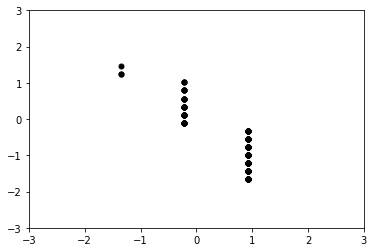

In [6]:
dp = data[59427]

fig = plt.figure()
plt.axis([-3,3,-3,3])

N = np.where(dp[:,3] == 1)[0][0] #How many strokes in this datapoint
 
x_tmp = np.cumsum(dp[:N,0])
x_tmp -= np.mean(x_tmp)
x_tmp /= np.std(x_tmp)
    
y_tmp = -np.cumsum(dp[:N,1]) #Negative because positive y is downwards
y_tmp -= np.mean(y_tmp)
y_tmp /= np.std(y_tmp)  

def animate(n):
    line, = plt.plot(x_tmp[:n], y_tmp[:n],'ko', markersize = 5)

    return line

anim = animation.FuncAnimation(fig, animate, frames=N, interval=20)

HTML(anim.to_jshtml())

## Preprocessing the Data
This preprocessing prepends null elements to each sequence.
A null element is in this case a vector of zeros $[0, 0, 0, 0]$

In [7]:
absolute_data = np.zeros_like(data)

for i, dp in enumerate(data):
    N = np.where(dp[:,3] == 1)[0][0] +1 #How many points in this datapoint
    
    # Normalize input data in
    # x-dimension
    x_tmp = np.cumsum(dp[:N,0])
    x_tmp -= np.mean(x_tmp)
    if(np.std(x_tmp) != 0):
        x_tmp /= np.std(x_tmp)
    # y-dimension
    y_tmp = -np.cumsum(dp[:N,1]) #Negative because positive y is downwards
    y_tmp -= np.mean(y_tmp)
    if(np.std(y_tmp) != 0):
        y_tmp /= np.std(y_tmp)  

    # Start at index -N:
    # This will cause the data to be prepended with zeros.
    absolute_data[i,-N:,0] = x_tmp
    absolute_data[i,-N:,1] = y_tmp
    absolute_data[i,-N:,2] = dp[:N,2]
    absolute_data[i,-N:,3] = dp[:N:,3]

In [8]:
absolute_data.shape

(70000, 117, 4)

In [9]:
np.save('absolute_and_padded_data_ordered.npy', absolute_data)

# Example printout of a sequence in the dataset.

In [10]:
absolute_data[0]

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.

# Interpolate with points instead of zero-pad

In [6]:
data = np.load('absolute_and_padded_data_ordered.npy')[:,:,:2]

In [234]:
def expand_array(array, target_size):
    
    target_array = array.copy()
    
    n = len(target_array)
    
    while(n < target_size):
        r = np.random.randint(n)
        
        x = target_array[r:r+2,:]
        x_middle = np.mean(x, axis = 0, keepdims=True)
        
        target_array = np.insert(target_array, r+1 , x_middle, axis = 0)
        
        n = len(target_array)
        
    return target_array
    

In [235]:
def contract_array(array, target_size):
    
    target_array = array.copy()

    
    n = len(target_array)
    
    while(n > target_size):
        
        r = np.random.randint(n)
        
        target_array = np.delete(target_array, r, axis = 0)
        
        n = len(target_array)
        
    return target_array

In [236]:
target_sequence_length = 60
absolute_interpolated_data = np.zeros((70000, target_sequence_length, 2))

In [237]:
for i, dp in enumerate(data):
    if(i%1000 == 0):
        print(i)
    N = np.argmax(dp.all(axis = 1))
    
    
    if(len(dp) - N > target_sequence_length):
        temp_dp = contract_array(dp[N:], target_sequence_length)
    else:
        temp_dp = expand_array(dp[N:], target_sequence_length)
            
    absolute_interpolated_data[i,:,:] = temp_dp
        

In [238]:
np.save('absolute_interpolated_data.npy', absolute_interpolated_data)

See if adding points distort input

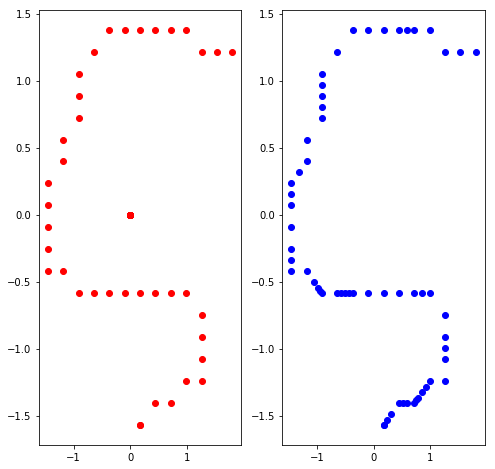

In [249]:
d = 2000

dp_true = data[d]
dp_inter = absolute_interpolated_data[d]

fig, ax = plt.subplots(1,2, figsize = (8,8))
ax[0].plot(dp_true[:,0], dp_true[:,1], 'ro')
ax[1].plot(dp_inter[:,0], dp_inter[:,1], 'bo')
plt.show()